In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache
from pysam import AlignmentFile

In [2]:
%matplotlib inline

In [3]:
ecx = pd.read_csv("assets/hg38ext.fa.ecx", sep="\t", skiprows=1, escapechar="#") \
    .query("flag==16384").query("blacklist=='-'") \
    .drop(columns=["entry", "pos+1", "main_rname", "flag", "link", "blacklist", "class"])

ecx["sorter"] = ecx["chromosome"].apply(lambda c: 999 if c == "chrX" else int(c[3:]))
ecx = ecx.sort_values(by="sorter").drop(columns="sorter")

In [4]:
def load_bam(filename):
    p_arm, q_arm = defaultdict(list), defaultdict(list)
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if (entry.flag & 0x4000 == 0x4000) and (entry.seq is not None) and (entry.flag & 3844 == 0): # tract_anchor
                entry_stats = [
                    entry.reference_start, entry.query_alignment_start,
                    entry.reference_end, entry.query_alignment_end,
                    len(entry.seq)
                ]
                if entry.flag & 0x8000 == 0x8000: # is_q
                    q_arm[entry.reference_name].append(entry_stats)
                else:
                    p_arm[entry.reference_name].append(entry_stats)
    return p_arm, q_arm

In [5]:
def get_chroms(ecx, p_arm, q_arm, blacklist=[]):
    chroms = []
    for c in ecx["chromosome"]:
        if ecx.loc[ecx["chromosome"]==c, "rname"].iloc[0] in (set(p_arm) | set(q_arm)):
            if (c not in chroms) and (c not in blacklist):
                chroms.append(c)
    return chroms

In [6]:
def get_reads(refdata, x_arm, prime):
    _x = refdata.loc[refdata["prime"]==prime, "rname"]
    if len(_x):
        if x_arm[_x.iloc[0]]:
            return _x.iloc[0], x_arm[_x.iloc[0]]
    return None, []

In [31]:
def init_figure(chroms, p_arm, q_arm, r=15000, rin=-20000, rout=12000, ymin=-19, b=-13, m=-9, t=-4, lw=.75, annot=True):
    maxcov = max(
        max(len(get_reads(ecx[ecx["chromosome"]==chrom], p_arm, 5)[1]), len(get_reads(ecx[ecx["chromosome"]==chrom], q_arm, 3)[1]))
        for chrom in chroms
    )
    n_chroms = len(chroms)
    figure, axs = subplots(
        figsize=(15, (maxcov-ymin)*n_chroms/40), gridspec_kw=dict(wspace=0, width_ratios=(7, 3, 7)),
        ncols=3, nrows=n_chroms, squeeze=False, sharey=True,
    )
    for j, row in enumerate(axs):
        for i, ax in enumerate(row):
            order = i - 1
            if i % 2 == 0:
                ax.set(xlim=[rin*order, rout*order][::order], ylim=(ymin, maxcov))
                ax.set(xticklabels=[int(t/1000) for t in ax.get_xticks()])
            else:
                ax.set(xlim=[-r, r], ylim=(ymin, maxcov), xticks=[0], xticklabels=["..."], yticks=[])
                ax.spines["bottom"].set_linestyle((0, (3, 10, 1, 10, 1, 10)))
            for spine in ["left", "top", "right"]:
                ax.spines[spine].set_visible(False)
            if i == 1:
                if j == axs.shape[0]-1:
                    ax.text(x=0, y=ymin*2.4, s="Position in Kbp, relative to boundaries of telomeric tracts", fontsize=13, ha="center")
                if annot:
                    ax.text(x=0, y=5, s="centromere", fontsize=12, ha="center")
            else:
                if annot:
                    sub_ha, tel_ha = ["right", "left"][::order]
                    ax.text(x=-order*r/20, y=m, s="subtelomere", fontsize=12, ha=sub_ha, va="center")
                    ax.text(x=order*r/20, y=m, s="telomere", fontsize=12, ha=tel_ha, va="center")
        xw = r/3
        for order in (1, -1):
            row[1].plot([-xw, xw], [t, b][::order], color="black", lw=lw)
            row[1].fill_between([xw*order, 0], [b, m], [t, m], color="#E0E0E0")
            for i in range(1, 8):
                row[1].plot([(xw+xw*i/3)*order]*2, [b, t], color="gray", lw=3)
        for ax, order in zip((row[0], row[2]), (1, -1)):
            ax.plot([0, 0], [b, t], lw=.75, color="black")
            for y in (t, b):
                ax.plot([0, -.95*rin*order], [y, y], lw=lw, color="black")
                ax.plot([0, -.95*rout*order], [y, y], lw=lw, color="black", ls="--")
            ax.fill_between([0, -.95*rin*order], [b, b], [t, t], color="#E0E0E0")
            ax.fill_between([0, -.95*rout*order], [b, b], [t, t], color="#EEF0FF")
        if annot:
            row[0].text(x=-12000, y=0, s="$p$ arm (5')", fontsize=12, ha="left")
            row[2].text(x=+12000, y=0, s="$q$ arm (3')", fontsize=12, ha="right")
    return figure, axs

In [15]:
def plot_pileup(chrom, p_arm, q_arm, ecx, pax, qax, ymin=-19):
    refdata = ecx[ecx["chromosome"]==chrom]
    p_ref, p_reads = get_reads(refdata, p_arm, 5)
    q_ref, q_reads = get_reads(refdata, q_arm, 3)
    if p_reads:
        anchor_pos = refdata.loc[refdata["prime"]==5, "pos"].iloc[0]
        plottables = []
        for rs, qs, re, qe, sl in p_reads:
            xe = re + (sl - qe) - anchor_pos
            xs = xe - sl
            plottables.append([xs, xe])
        for i, (xs, xe) in enumerate(sorted(plottables, key=lambda x:x[1], reverse=True)):
            pax.plot([xs, 0], [i, i], color="darkblue", lw=.75)
            pax.plot([0, xe], [i, i], color="gray", lw=.75)
    if q_reads:
        anchor_pos = refdata.loc[refdata["prime"]==3, "pos"].iloc[0]
        for i, (rs, qs, re, qe, sl) in enumerate(sorted(q_reads)):
            xs = rs - anchor_pos
            xe = xs + (sl - qs)
            qax.plot([xs, 0], [i, i], color="gray", lw=.75)
            qax.plot([0, xe], [i, i], color="darkblue", lw=.75)
    for ax, reads in zip((pax, qax), (p_reads, q_reads)):
        ax.plot([0, 0], [ymin, len(reads)], color="#EE3333", lw=2, ls="--")

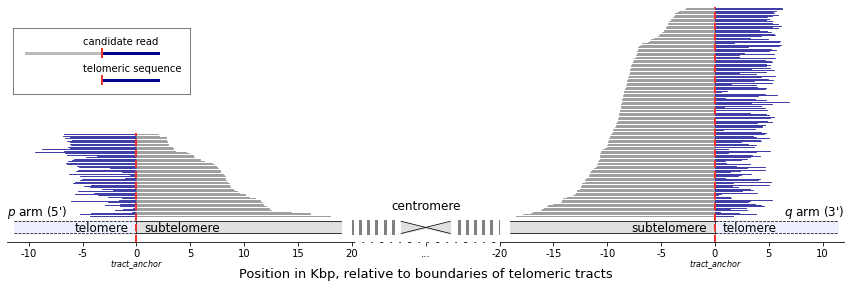

In [137]:
def add_custom_legend(cax):
    cax.plot([-10300, -3000], [120, 120], lw=3, color="#BBB")
    cax.plot([-3000, 2000], [120, 120], lw=3, color="darkblue")
    cax.plot([-3200, -3200], [117, 123], lw=2, color="#EE3333")
    cax.text(x=-5000, y=126, s="candidate read")
    cax.plot([-3000, 2000], [100, 100], lw=3, color="darkblue")
    cax.plot([-3200, -3200], [97, 103], lw=2, color="#EE3333")
    cax.text(x=-5000, y=106, s="telomeric sequence")
    cax.plot([-11500, 5000], [138, 138], lw=.5, color="black")
    cax.plot([-11500, -11500], [90, 138], lw=.5, color="black")
    cax.plot([-11500, 5000], [90, 90], lw=.5, color="black")
    cax.plot([5000, 5000], [90, 138], lw=.5, color="black")

p_arm, q_arm = load_bam("PacBio/AshkenazimTrio/HG002/tailpuller.bam")
chroms = get_chroms(ecx, p_arm, q_arm)
chroms = ["chr5"]

figure, axs = init_figure(chroms, p_arm, q_arm, annot=True)
for chrom, (pax, cax, qax) in zip(chroms, axs):
    plot_pileup(chrom, p_arm, q_arm, ecx, pax, qax)
    for ax in pax, qax:
        ax.text(x=0, y=-31, s="$tract\_anchor$", va="top", ha="center", fontsize=8)
    add_custom_legend(pax)

figure.savefig("Figure 1.pdf", bbox_inches="tight")